## IMPORTS

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

In [2]:
from scipy.io import loadmat
from scipy.signal import decimate, stft

In [3]:
from sklearn.preprocessing import RobustScaler

In [4]:
from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack

In [5]:
from os import path, walk

## LOAD DATA

In [6]:
#data = loadmat("Patient_1_interictal_segment_0001.mat")
#interictal_segment_1 = data['interictal_segment_1'][0][0][0]

#mat files = original data at 5000 Hz

In [9]:
def load_full_series(subject=str, name=str, number_of_files=int):
    full_df = pd.read_csv(f'{subject}_csv/{name}_segment_1.csv')
    for index in range(2, number_of_files+1): 
        print("Processing file #", index)
        temp = pd.read_csv(f'{subject}_csv/{name}_segment_{index}.csv')
        #get length of dataframe and define segmentation factor
        
        #temp = pd.DataFrame(scaler(temp)) #scale the data

        full_df = full_df.merge(temp,left_index=True, right_index=True)
        #print(full_df.shape)
    
    return full_df

### Downsample (100x)

### Scale

In [6]:
def scaler(df):
    return RobustScaler().fit_transform(df)

## BASELINE: get statistics for all the data by segments of 1000 datapoints

In [ ]:
def stats_array_1000_points(subject=str, name=str,  number_of_files=int):

    stats = [] #list to store the segment stats
    
    for index in range(1, number_of_files+1): 
        print("Processing file #", index)
        temp = pd.read_csv(f'{subject}_csv/{name}_segment_{index}.csv')
        #get length of dataframe and define segmentation factor
        idx = int(temp.iloc[0].shape[0]/(len(temp.iloc[0])/1000))
        # dividing by 30 --> 1000 datapoints segments

        temp = pd.DataFrame(scaler(temp)) #scale the data

        i = 0

        while i < temp.iloc[0].shape[0]:
            for x in range(temp.shape[0]):
                segment = temp.iloc[x][i:idx+i]
                stats.append([x, np.mean(segment), np.median(segment), np.std(segment), np.var(segment)])

            i = idx+i
    return stats

In [ ]:
def plot_sensor(stats_list, index):  #index = electrode number
    mu = []
    med = []
    std = []
    var = []

    for i in stats_list:   #plot the stats for the first sensor
        if i[0] == index:
            mu.append(i[1])
            med.append(i[2])
            std.append(i[3])
            var.append(i[4])

    plt.figure(figsize=(20,15))
    plt.xlim(0, len(mu))
    plt.ylim(-1,1.5)
    plt.plot(mu, label='mean')
    plt.plot(med, label='median')
    plt.plot(std, label='standard deviation')
    plt.plot(var, label='variance')
    plt.legend()

### Interictal data

In [ ]:
interictal_stats = stats_array_1000_points('Patient_1', 'interictal', 50)

In [ ]:
plot_sensor(interictal_stats, 8)

### Preictal data

In [ ]:
preictal_stats = stats_array_1000_points('Patient_1', 'preictal', 18)

In [ ]:
plot_sensor(preictal_stats, 8)

### Compare with the ictal dataset

In [ ]:
#An actual epilepsy crisis recording, just for comparing with the interictal & preictal data.

ictal = []
for i in range(1,51):
    ictal.append(loadmat(f"EEG_Epilepsy_Datasets/ictal/ictal{i}.mat")['ictal'])
ictal = np.reshape(ictal, -1)

idx = int(ictal.shape[0]/(len(ictal)/100))

ictal_stats = []
i = 0

while i < ictal.shape[0]:
    segment = ictal[i:idx+i]
    segment = scaler(segment.reshape(-1,1))
    ictal_stats.append([np.mean(segment), np.median(segment), np.std(segment), np.var(segment)])
    i = idx+i
    
mu = []
med = []
std = []
var = []

for i in ictal_stats:
        mu.append(i[0])
        med.append(i[1])
        std.append(i[2])
        var.append(i[3])

plt.figure(figsize=(20,15))
ax = plt.gca()
ax.set_xlim([0,len(ictal_stats)])
ax.set_ylim([-0.5,2])
plt.plot(mu, label='mu')
plt.plot(med, label='median')
plt.plot(std, label='std')
plt.plot(var, label='variance')
plt.legend()

### All the above = not useful

## Frequencies & Fourier Transform

### Functions

In [24]:
#Brain waves frequencies

def decompose_brainwaves(data):
    delta = (0,4)
    theta = (4.5,8)
    alpha = (8.5,12)
    beta = (12.5,35)
    gamma = (35, 100)
    zeta =(1000, 2000)

    frequencies = rfftfreq(data.size, d=1/data.size)

    fourier = rfft(data)
    
    output = []
    for i in (alpha, beta, delta, theta, gamma, zeta):
        #print(i)
        ft_threshed = fourier.copy()
        ft_threshed[(frequencies < i[0])] = 0
        ft_threshed[(frequencies > i[1])] = 0 
        output.append(irfft(ft_threshed))
    
    return output

def plot_brainwaves(data, subject=str):
    fig, axarr = plt.subplots(len(data), figsize=(20, 12))
    for i, signal in enumerate(data):
        plt.sca(axarr[i])
        plt.plot(signal)
    plt.gcf().suptitle(f"frequency bands: {subject} data", fontsize=24)
    

def plot_single_wave(data, label=str):
    plt.figure(figsize=(20,12))
    plt.xlim=(0,len(data))
    plt.ylim=(-0.75,0.75)
    sns.lineplot(data=data, label=label)
    plt.legend()
    plt.gcf().suptitle(f"Gamma band: {label}", fontsize=24)

In [ ]:
#functions for sorting the file list by segment number, found on stackoverflow.
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# I have no freaking idea how this works.

In [ ]:
def variance_evolution(subject=str):

    filelist = []
    
    for root, dirs, files in walk(f'./{subject}'):
        for f in files:
            if 'preictal' in f:
                filelist.append(f)

    sort_nicely(filelist)
    
    variances = pd.DataFrame(columns=range(len(filelist))) #dataframe to store the variance for each segment/sensor
    
    for root, dirs, files in walk(f'./{subject}'):
        for i in filelist:
            print(i)
            temp = pd.read_csv(path.join(root, i))
            temp = pd.DataFrame(scaler(temp))
            #print(temp)
            for j in range(temp.shape[0]):   #iterate through all sensors
                variances.loc[j, filelist.index(i)] = np.var(decompose_brainwaves(temp.iloc[j])[4])  #index 4 = gamma band
                #print(variances.iloc[j])
            
    
    return variances

##### PERHAPS INTERESTING - LATER

import scipy
import scipy.fftpack
import pylab
from scipy import pi
t = scipy.linspace(0,120,4000)
acc = lambda t: 10*scipy.sin(2*pi*2.0*t) + 5*scipy.sin(2*pi*8.0*t) + 2*scipy.random.random(len(t))

signal = acc(t)

FFT = abs(scipy.fft(signal))
freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])

pylab.subplot(211)
pylab.plot(t, signal)
pylab.subplot(212)
pylab.plot(freqs,20*scipy.log10(FFT),'x')
pylab.show()

### Demo : frequency bands

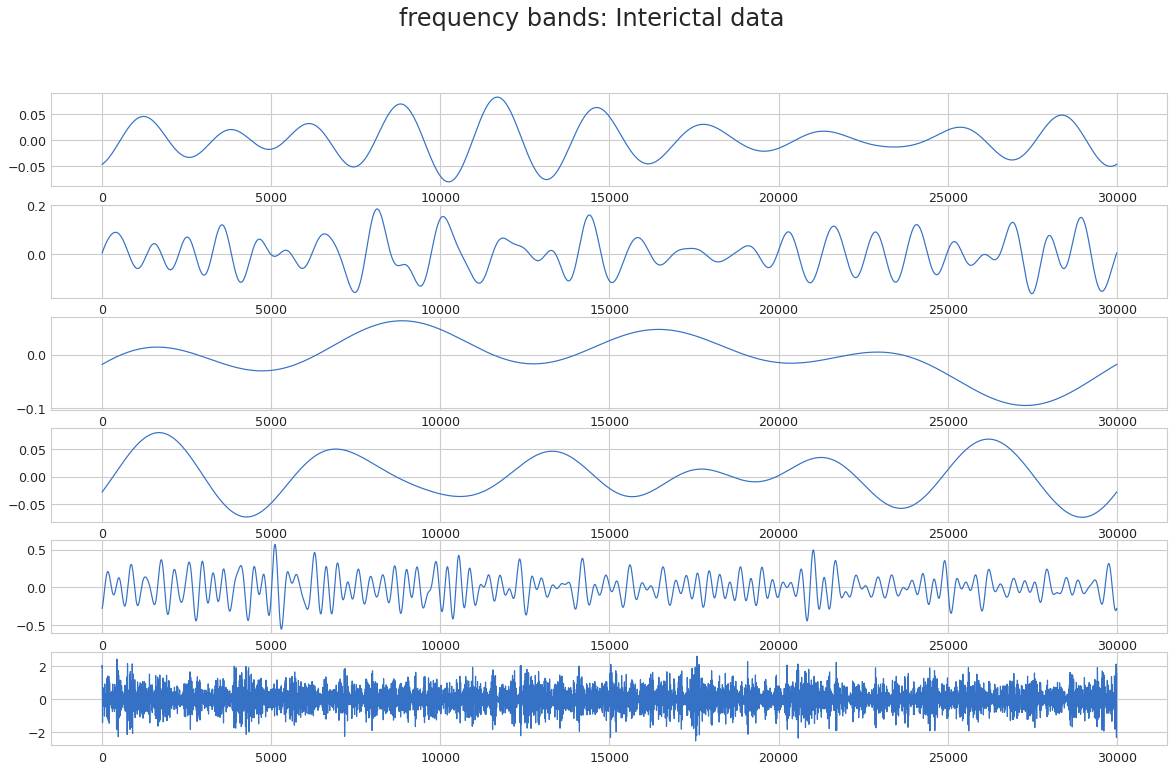

In [26]:
demo = pd.read_csv('Patient_2_csv/preictal_segment_1.csv')
plot_brainwaves(decompose_brainwaves(pd.DataFrame(scaler(demo)).iloc[0]), 'Interictal')                   

<br>
<center><b style="color:blue; font-size:24px">Only the last band seems useful<b><center>
<br>

### Comparing first and last interictal & preictal segments

In [ ]:
interictal_segment_first = pd.read_csv('Patient_1_csv/interictal_segment_1.csv')

interictal_segment_last = pd.read_csv('Patient_1_csv/interictal_segment_45.csv') #actually 45th out of 50

preictal_segment_first = pd.read_csv('Patient_1_csv/preictal_segment_1.csv')

preictal_segment_last = pd.read_csv('Patient_1_csv/preictal_segment_18.csv')

In [ ]:
temp = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_first)).iloc[0])
temp1 = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_last)).iloc[0])
temp2 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_first)).iloc[0])
temp3 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_last)).iloc[0])

In [ ]:
plot_single_wave(temp[4])
plot_single_wave(temp1[4])
plot_single_wave(temp2[4])
plot_single_wave(temp3[4])

In [ ]:
plot_brainwaves(decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_last)).iloc[0]), 'Last Interictal')                   

In [ ]:
plot_brainwaves(decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_last)).iloc[0]), 'Last Preictal')                   

In [ ]:
temp = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_first)).iloc[0])

temp1 = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_last)).iloc[0])

temp2 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_first)).iloc[0])

temp3 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_last)).iloc[0])

In [ ]:
plt.figure(figsize=(20,10))
plt.xlim=(0,len(temp[4]))
plt.ylim=(-0.75,0.75)
sns.lineplot(data=temp[4], label='interictal_first')
sns.lineplot(data=temp1[4], label='interictal_last')
#sns.lineplot(data=temp2[4], label='preictal_first')
#sns.lineplot(data=temp3[4], label='preictal_last')
plt.legend()

In [ ]:
print('Interical first variance:', np.var(temp[4]))
print('Interical last variance:', np.var(temp1[4]))
print('Preictal first variance:', np.var(temp2[4]))
print('Preictal last variance:', np.var(temp3[4]))

### Plot the variance evolution for the entire dataset

In [ ]:
variances_patient_1 = variance_evolution('Patient_1_csv')

In [ ]:
plt.figure(figsize=(20,15))
for i in range(variances_patient_1.shape[0]):
    plt.plot(variances_patient_1.iloc[i], label=i);
plt.legend()
plt.title('Variance Evolution - Patient 1');

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(variances_patient_1.astype('float64').corr());
plt.title('Correlation map');

In [ ]:
variances_patient_2 = variance_evolution('Patient_2_csv')

In [ ]:
plt.figure(figsize=(20,15))
for i in range(variances_patient_2.shape[0]):
    plt.plot(variances_patient_2.iloc[i], label=i);
plt.legend()
plt.title('Variance Evolution - Patient 2');

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(variances_patient_2.astype('float64').corr());
plt.title('Correlation map');

In [10]:
full_pre_patient2 = load_full_series('Patient_2','preictal', 18)

Processing file # 2
(24, 60000)
Processing file # 3
(24, 90000)
Processing file # 4
(24, 120000)
Processing file # 5
(24, 150000)
Processing file # 6
(24, 180000)
Processing file # 7
(24, 210000)
Processing file # 8
(24, 240000)
Processing file # 9
(24, 270000)
Processing file # 10
(24, 300000)
Processing file # 11
(24, 330000)
Processing file # 12
(24, 360000)
Processing file # 13
(24, 390000)
Processing file # 14
(24, 420000)
Processing file # 15
(24, 450000)
Processing file # 16
(24, 480000)
Processing file # 17
(24, 510000)
Processing file # 18
(24, 540000)


In [11]:
full_pre_patient1 = load_full_series('Patient_1','preictal', 18)

Processing file # 2
(15, 60000)
Processing file # 3
(15, 90000)
Processing file # 4
(15, 120000)
Processing file # 5
(15, 150000)
Processing file # 6
(15, 180000)
Processing file # 7
(15, 210000)
Processing file # 8
(15, 240000)
Processing file # 9
(15, 270000)
Processing file # 10
(15, 300000)
Processing file # 11
(15, 330000)
Processing file # 12
(15, 360000)
Processing file # 13
(15, 390000)
Processing file # 14
(15, 420000)
Processing file # 15
(15, 450000)
Processing file # 16
(15, 480000)
Processing file # 17
(15, 510000)
Processing file # 18
(15, 540000)


In [13]:
full_pre_patient1.to_csv('full_preictal_1')
full_pre_patient2.to_csv('full_preictal_2')

In [ ]:
from scipy.signal import welch

In [ ]:
welch(variances_patient_1.iloc[0])

In [ ]:
variances_patient_1.iloc[0]

## CONVERTING THE FREQUENCIES INTO SOUND ?

In [ ]:
import librosa
from librosa import display

In [ ]:
from IPython.display import Audio

In [ ]:
samples, sampling_rate = librosa.load('test.wav', 
                                      sr=None, mono=True, offset=0.0, duration=None)

In [ ]:
plt.figure(figsize=(20,15))
librosa.display.waveplot(y=np.array(interictal_segment_last.iloc[0]), sr=5000, label='Interictal Last')
librosa.display.waveplot(y=np.array(interictal_segment_1.iloc[0]), sr=5000, label='Interictal First')
plt.legend()


In [ ]:
max(preictal_segment_last.iloc[0])

In [ ]:
plt.figure(figsize=(20,15))
sns.lineplot(data=preictal_segment_first.iloc[0])
#plt.plot(preictal_segment_last.iloc[0])


In [ ]:
plt.figure(figsize=(20,15))

librosa.display.waveplot(y=np.array(preictal_segment_last.iloc[0]), sr=5000, label='Preictal Last')
librosa.display.waveplot(y=np.array(preictal_segment_first.iloc[0]), sr=5000, label='Preictal First')
plt.ylim=(-1000,1000)
plt.legend()

In [ ]:
from scipy.io import wavfile

In [ ]:
wavfile.write('test2.wav', rate=5000, data=interictal_segment_last.iloc[0])

In [ ]:
samples, sampling_rate = librosa.load('test2.wav', 
                                      sr=None, mono=True, offset=0.0, duration=None)

In [ ]:
samples[0]

In [ ]:
interictal_segment_last.iloc[0]

In [ ]:
sampling_rate

In [ ]:
with open('test1.wav', 'wb') as f:
    f.write(Audio(interictal_segment_last.iloc[0], rate=5000).data)

In [ ]:
Audio(np.array(preictal_segment_first.iloc[0]), rate=5000)

In [ ]:
Audio(np.array(preictal_segment_last.iloc[0]), rate=5000)